# Vector Alternative

## Earlier work

Previously I used Hall's method for applying DP to functions.

I found a bound which applied to any test point $x_*$. I then tried to alter this to just consider the greatest bound for the test points used (i.e. calculate the exact bound for each test point, and use that to calculate $\Delta$). But it turns out I can't use as the sensitivity the test point with the highest sensitivity as I need to bound the whole function: It is almost certain that combining the results of more than one test point in a joint probability distribution will leak more information, I think is the issue.

I also looked into manipulating the covariance function by: 

 - Altering the noise variance of each training point
 - Scaling the kernel by the cloaking function
 
> Note: I've not investigated the effect of using such modified covariance functions much: it seems to behave quite strangely. The problem is its interaction with the sensitivity. Maybe something to look into later.

## Noise direction

It is worth reasoning about the direction of the noise that's added, and compare it to the effect of modifying a training point. I think the sensitivity in the earlier methods needs to be quite high because the noise added (sampled from the *prior*) is not necessarily in the direction a perturbation in a training output would cause.

Consider the simple case of two training and two test points as in this figure;

#### Figure 1
<img src="demo_problem_with_standard_fn_noise.png" />

Put simply: We're interested in the effect of changing the training outputs on the test outputs. Specifically what's the largest change in the mean of the prediction at the test points, given a unit change in one of the training points?

Using the method developed in the earlier version of the paper we add noise with correlations defined by the default kernel (i.e. from the **prior**). In the following figure the shaded contour plot shows the distribution of DP noise added to two nearby test points. The two axes are for the two test points above (x-axis, left point; y-axis, right point). 

The lined contours are the same noise, but for when the training data has been *perturbed*, as in the above figure. The y-axis represents the right test point, and, as this has moved due to the perturbation, the gaussian has shifted upwards. Because the other training point wasn't affected the gaussian has not shiften along the x-axis.

#### Figure 2
<img src="problem.png" />

If the other training point were to move, the gaussian would be shifted rightward and *downward* (think about how the right test point would move if the left training point moved up).

In this case I've reduced the $\Delta$ of the DP so the two gaussians don't overlap too much. But for DP to exist the $\Delta$ must be large enough that the two distributions overlap sufficiently. It seems to me that the direction of the Gaussian noise is wrong, and that it needs to point in the direction which means the $\Delta$ is as small as possible.

To this end, I went back to an earlier step in the Hall paper, for a bound on a vector rather than a function. This means, I think, I can add whatever gaussian I want (the covariance of the gaussian doesn't have to match the kernel).

Copied from the paper:

> Proposition 3: Suppose that, for a positive definite symmetric matrix $M \in \mathbb{R}^{d \times d}$, the family of vectors $\{\mathbf{v}_D : D \in \mathcal{D}\} \subset \mathbb{R}^d$
>
> $$sup_{D \sim {D'}} ||M^{-1/2} (\mathbf{v}_D - \mathbf{v}_{D'})||_2 \leq \Delta\;\;\;\;\;(1)$$
>
> Then the randomized algorithm which, for input database D outputs
>
> $$\tilde{\mathbf{v}_D} = \mathbf{v}_D + \frac{c(\delta)\Delta}{\alpha}Z\;\;\;\;\;(2)$$
>
> where $$Z \sim \mathcal{N}_d(0,M)$$
>
> achieves $(\varepsilon, \delta)$-DP whenever,
>
> $$c(\delta) \geq \sqrt{2 log \frac{2}{\delta}}$$

We want to construct $M$ so that it has greatest covariance in those directions most affected by changes in test points. This has the intuitive result that it will mask those changes, and the mathematical result that its square-root inverse, $M^{-\frac{1}{2}}$, will scale-down the test-perturbation $(\mathbf{v}_D - \mathbf{v}_{D'})$ most in those 'directions' in which it's greatest.

We build the matrix $K$ to represent the covariance between all training points, with the sample variance built in, i.e. $K_{i,i} = k(x_i,x_i) + \sigma^2$.

The prediction at test point $x_*$ has mean $\mathbf{k}_* K^{-1} \mathbf{y}$ where $\mathbf{k}_*$ is the covariance between test point $x_*$ and all the training points. We can find the predictions for all test points if we consider the matrix $K_{*f}$, the covariance between all test and training points.

$$\mathbf{y}_* = K_{*f} K^{-1} \mathbf{y}$$

Given an element $y_i$ changes by $\partial y_i$, how much do the test points $\partial \mathbf{y}_*$ change?

Finding this $\frac{\partial \mathbf{y}_*}{\partial \mathbf{y}}$:

$$\frac{\partial}{\partial \mathbf{y}} \mathbf{y}_* = K_{*f} K^{-1}$$

We call this matrix the cloaking matrix, $C = K_{*f} K^{-1}$.

As the gradient is constant for all values of $\mathbf{y}$ (consider the second derivative wrt $\mathbf{y}$ to confirm) we can write the perturbed test values $\mathbf{y}_*'$ as:

$$\mathbf{y}_*' = \mathbf{y}_* + K_{*f} K^{-1} \left(\mathbf{y}' - \mathbf{y} \right)$$

$y_i' = y_i + \delta_y$, where $\delta_y$ is the amount of perturbation. This the only random variable (i.e. $y_i$ is the only training output value perturbed) so the above expression becomes:

$$\mathbf{y}_*' = \mathbf{y}_* + C_{:i} \delta_y\;\;\;\;\;\; (1)$$


We are interested in the covariance of our test points:

$$\langle \left(\mathbf{y}_*' - \langle \mathbf{y}_*' \rangle \right)\left( \mathbf{y}_*' - \langle \mathbf{y}_*' \rangle \right)^\top \rangle_{\delta_y} \;\;\;\;\;\; (2) $$

We define $\langle y_i' \rangle_{\delta_y} = y_i$, i.e. the perturbation we expect is symmetric. So $\langle \delta_y \rangle_{\delta_y} = \langle y_i' - y_i \rangle_{\delta_y} = 0$ so $\langle C_{:i} \delta_y \rangle_{\delta_y} = 0$. Therefore, using (1): $\langle y_*' \rangle_{\delta_y} = \langle y_* \rangle_{\delta_y} + 0$. Substituting into (2), we note that the covariance can use $y_*$ as its means: $\langle (\mathbf{y}_*' - \mathbf{y}_*)( \mathbf{y}_*' - \mathbf{y}_*)^\top \rangle_{\delta_y}$

which using (1) is: $\langle (\delta_y C_{:i})(\delta_y C_{:i})^\top \rangle_{\delta_y}$

So the covariance over test points, due to a perturbation of $\delta_y$ on training point $i$, is: $\delta_y^2 C_{:i} \; C_{:i}^\top$ with mean zero.

### Summary 
For a perturbation in training point $y_i$ of scale no greater than $\Delta_y$, $\left(v_D - v_D' \right)$ has mean zero, and covariance no greater than $\Delta_y C_{:i} \; C_{:i}^\top$. 

We assume we can find a matrix $P$ which bounds the covariance for all $i$; i.e. for all $i$, and for all vectors $\mathbf{e}$, $||\Delta_y P^{1/2} \mathbf{e}||_2 \geq ||\Delta_y [C_{:i} C_{:i}^\top]^{1/2} \mathbf{e}||_2$

To find the maximum values of $\left(v_D - v_D' \right)$ we make $\Delta_y$ the maximum change in the training outputs. Therefore we can treat $sup_u \left[P^{1/2} \mathbf{u} \Delta_y\right]$ as a bound on the perturbation, where $\mathbf{u}$ is a unit vector along one axis, and $\mathbf{u} \Delta_y = \mathbf{y}' - \mathbf{y}$.

We want to pick $M$ to be as small as possible to minimise the noise added, but also want $sup_{D \sim D'} ||\Delta_y M^{-1/2} P^{1/2} \mathbf{u}||_2$ to be small (as this also controls the scale of the noise added).

If we let $M = P$ then the above becomes $sup_{D \sim D'} ||\Delta_y \mathbf{u}||_2$, and as $\Delta_y \mathbf{u}$ is a vector of length $\Delta_y$, this bound will always be $\Delta_y$. Note that the actual value will probably be less, as $P$ will be constructed to protect against any training point's perturbation. We'll look into this next:

### Building P
 
$P$ describes the shape of the noise to add to the prediction. It needs to be shaped so that no training point perturbation can cause a change in predictions with covariance greater than $P$, in any direction.

#### Naive approach

To achieve this, I suggest the following algorithm:

1. Initialise $P$ as $\upsilon I$, for a small $\upsilon$.
2. For each training point, $i$:
    1. Let $Q = P^{-1}$. This will be the matrix we use to transform the candidate covariance
    2. Find $F = Q C_{:i} \; C_{:i}^\top$. This is the covariance of test points for perturbation of training point i, when transformed by the inverse of the current $P$. We effectively are making $P$ into a unit hypersphere. If our transformed candidate covariance exceeds this sphere in any direction then we need to modify $P$.
    3. Find the eigenvalues and eigenvectors of $F$.

While any eigenvalues are greater than one, add to $P$ a fraction of $F$ and repeat A-C.

This works, but it adds more noise than is necessary.


#### Scaling in direction of greatest sensitivity

The figure, roughly based on the example at the top of the document, demonstrates the advantages of adding noise in the direction of greatest sensitivity.

<img src="adding_noise.png" width=600 />

I suspect we can provide a much lower noise bound if we just scale in those directions that we need to.

1. Initialise $P$ as $\upsilon I$, for a small $\upsilon$.
2. For each training point, $i$:
    1. Let $Q = P^{-1}$. This will be the matrix we use to transform the candidate covariance
    2. Find $F = Q C_{:i} \; C_{:i}^\top$. This is the covariance of test points for perturbation of training point i, when transformed by the inverse of the current $P$. We effectively are making $P$ into a unit hypersphere. If our transformed candidate covariance exceeds this sphere in any direction then we need to modify $P$.
    3. Find the eigenvalues and eigenvectors of $F$.
    4. For each eigenvalue greater than one:
        1. Find the matrix R which will rotate the associated eigenvector to face along the first axis (provided by the eigenvector matrix?)
        2. Apply this transform to $P$, $P' = RP$ 
        3. Scale along x-axis by the size of the eigenvalue (or its square root???) $P'' = DP'$
        4. Apply the inverse of $R$: $P_{new} = R^{-1}P''$
        
        Summary: $P_{new} = R^{-1} P D R$
       
In other words, the covariance of $C_{:i} \; C_{:i}^\top$ should 'fit' inside the covariance $P$. If it doesn't, we need to scale $P$.

#### Problem

I thought that rotations and positive scalings would;

1. ensure the matrix remained positive semidefinite
2. ensure the final covariance matrix will protect the sensitivity (Delta<=1)

It seems neither is true, but I'm at a loss as to explain why.

# Demonstration

Below we use the naive method for generating $P$. I suspect considerable further savings in noise are possible if this is done more precisely. A really simple example, if we have two covariances to mask,
$
\begin{bmatrix}
    2 & 1 \\
    1 & 2 \\
\end{bmatrix}
$
and
$
\begin{bmatrix}
    2 & -1 \\
    -1 & 2 \\
\end{bmatrix}
$
we could just add them, and the new, distribution with covariance $
\begin{bmatrix}
    4 & 0 \\
    0 & 4 \\
\end{bmatrix}
$
will mask both of them. However, I think that one can do better. For example, the covariance;
$
\begin{bmatrix}
    3 & 0 \\
    0 & 3 \\
\end{bmatrix}
$
will also provide sufficient noise for the two examples above (so $\Delta \leq 1$) but also adds less when sampled from later.

The figure below demonstrates this a little more:

- The red and blue ellipses are the first two covariance distributions. We need to find one distribution which has sufficient noise to 'mask' them both.
- Adding them together gives us the solid black circle.
- But we can do better with a smaller variance (thin black circle)

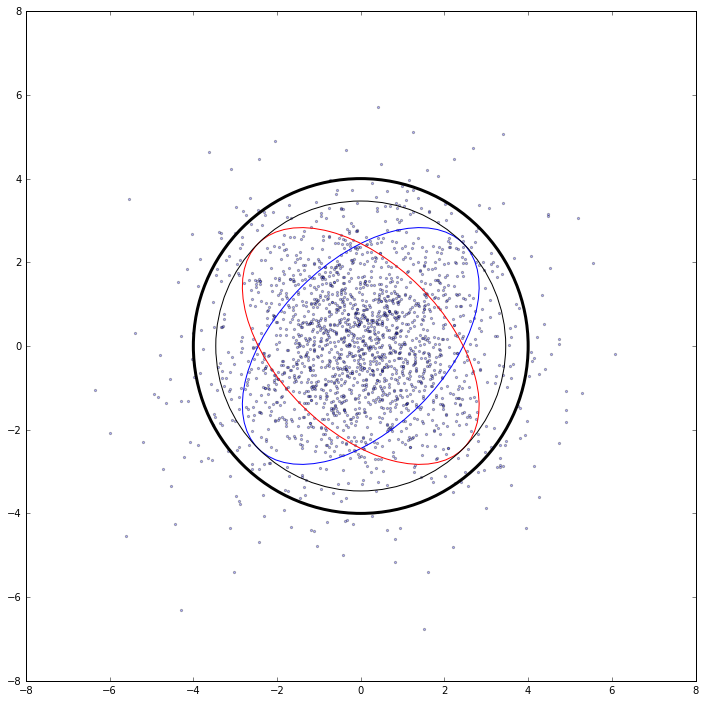

In [96]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from matplotlib.patches import Ellipse
fig = plt.figure(0,figsize=[12,12])
ax = fig.add_subplot(111, aspect='equal')

def plotcov(C,color='blue',lw=3):
    evals, evecs = np.linalg.eig(C)
    samps = np.random.multivariate_normal(np.zeros(2),C,500)
    ax.scatter(samps[:,0],samps[:,1],marker='.',alpha=0.3)
    ang = np.rad2deg(np.arctan2(evecs[0,0],evecs[1,0]))
    ax.add_artist(Ellipse(xy=[0,0], width=4*np.sqrt(evals[0]), height=4*np.sqrt(evals[1]), angle=ang, lw=lw, ec=color, fc='none'))
plotcov(np.array([[2,1],[1,2]]),'b',1)
plotcov(np.array([[2,-1],[-1,2]]),'r',1)

plotcov(np.array([[4,0],[0,4]]),'k',3)
plotcov(np.array([[3,0],[0,3]]),'k',1)

#### Actual Implementation

Below is a simple demo of the above ideas, this uses the *naive* method (of just adding the covariances).

Delta = 0.99


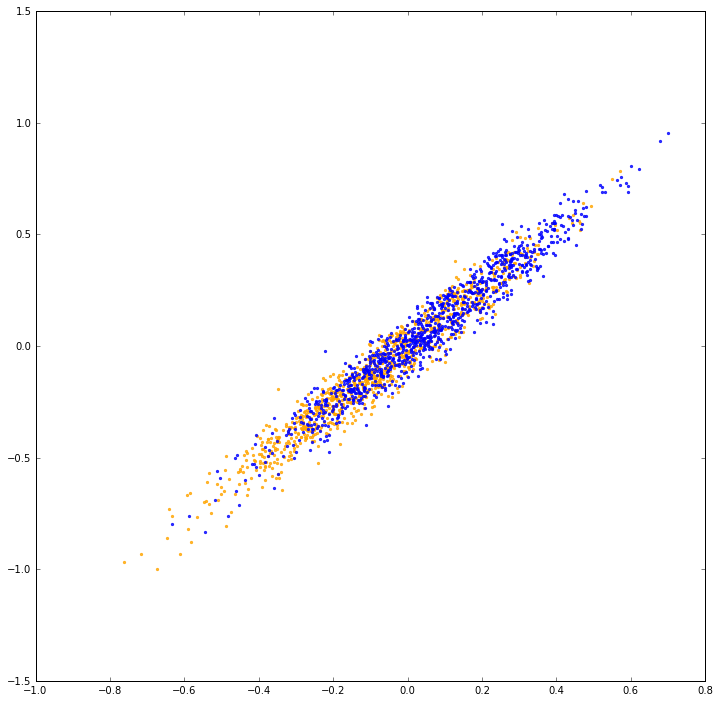

In [161]:
import GPy
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
%matplotlib inline

def k(x1,x2,l):
    """
    The kernel function
     l = lengthscale"""
    return np.exp(-.5 * (x1-x2)**2/l**2)

#The test and training input locations
tests = np.arange(-10,20,0.5) #np.array([0.0,1.0,2.0]) #np.arange(-5,15,1.0) #
train = np.arange(0,10,0.1) #np.array([0.0,1.5]) #np.arange(0,5,0.1) # #

#other parameters (lengthscale, noise-std, (eps,delta)-DP)
l = 4.0
sigma = 1.0
delta = 0.01
eps = 2.0
sens = 8 #sens=\Delta_y i.e. how much the outputs can vary by.

#calculate covariance between test+train, and between training points
Kstar = np.zeros([len(tests),len(train)])
for i,x in enumerate(tests):
    for j,y in enumerate(train):
        Kstar[i,j] = k(x,y,l)
K = np.zeros([len(train),len(train)])
for i,x in enumerate(train):
    for j,y in enumerate(train):
        K[i,j] = k(x,y,l)
K+=sigma**2*np.eye(len(train)) #add diagonal sample noise variance

#cloak is a matrix describing how much each training point affects each test point
cloak = np.dot(Kstar,np.linalg.inv(K))

#cov is the P matrix discussed above. We need to build it to hide the
#covariance caused by manipulating each training point...
#at the moment this uses the naive method.

#start with almost no noise 
#(making this quite big helps at the moment due to the naive method for combining the covariances
#if this were very small the method would add noise from more covariances)
cov = np.eye(len(tests))*0.00001

#for each training input...
for it in np.random.permutation(range(len(train))):
    #newcov is the amount of covariance between test points (when we perturb training point i)
    newcov = (np.dot(cloak[:,it][:,None],cloak[:,it][None,:]))
    #We scale this newcov by the inverse of cov to test if all of newcov is inside cov. If any
    #of (cov^-1 . newcov)'s eigen values > 1 then that suggests that there are directions we
    #need to increase the variance of...
    evals,evects = np.linalg.eig(np.dot(np.linalg.inv(cov),newcov))
    #so while any eigenvalues > 1, make the covariance matrix bigger!
    while np.any(evals>1.0):        
        cov += newcov * 0.05 #we add small increments as we might get away with less than adding all of newcov.
        #calculate new eigenvalues
        evals,evects = np.linalg.eig(np.dot(np.linalg.inv(cov),newcov))

#to find Delta, we need to find P^-.5 (P is cov here)
halfcov = np.real(scipy.linalg.sqrtm(cov)) #occasionally goes minutely complex.
invhalfcov = np.linalg.inv(halfcov) #C^{-.5}

assert np.sum(np.dot(halfcov,halfcov)-cov)<0.001 #(P^.5).(P^.5) should equal P.

#cloak is a matrix which describes the effect of every training point on every test point
#so the columns of M^-.5 x cloak are the results of   M^-.5 (v_D - v_D')   for each training input
#we are interested in the greatest value of M^-.5 (v_D - v_D') = M^-.5 x Cloak. 
#The result of that product is a matrix with each column holding the M scaled effect of
#perturbing a training point.
#we therefore need to find ||.||_2 of each column, and then find the maximum of these norms.
#
#(note, could swap order of sqrt and max, to save compute)

inner = np.dot(invhalfcov,cloak) #this is how much M^-.5 (v_D - v_D') move for each test/training point pair
Delta = np.max(np.sqrt(np.sum(inner**2,0))) #here we find the norm_2 for each column, and find the max of these norms

print("Delta = %0.2f" % Delta) #we expect this to be <=1 because of our method for creating M (cov)

#DP calculation to find scaled GP DP noise samples
c = np.sqrt(2*np.log(2/delta))
sampcov = ((sens*c*Delta/eps)**2)*cov
samps = np.random.multivariate_normal(np.zeros(len(tests)),sampcov,1000)

##Plot the samples (with GP mean added)
plt.figure(figsize=[12,12])

#NOTE! It is only here that we need to know the output values! (we make the source function just y=x)
y = train.copy()

#GP mean prediction
mu = np.dot(Kstar,np.dot(np.linalg.inv(K),y))

#get our DP predictions
fsamps = mu+samps

plt.scatter((fsamps)[:,0],(fsamps)[:,1],marker='.',color='orange',alpha=0.8)
y[0]+=sens
mu_shift = np.dot(Kstar,np.dot(np.linalg.inv(K),y))
plt.scatter((mu_shift+samps)[:,0],(mu_shift+samps)[:,1],marker='.',color='b',alpha=0.8)
y[0]-=sens

The points in the above figure show the output of two test points with DP noise added. The shifted set of points is for the same test points but with one training y value perturbed by the maximum it can be (sens or $\Delta_y$).

In the figure above one can see that the perturbation causes both test point predictions to increase. One can also see that the DP noise has a covariance that points in that direction. This is the fundamental idea here: We're adding noise in those directions that perturbations cause our outputs to move in.

#### Numerical check

For checking our code is ok - we could actually check that the output is DP numerically.

A numerical check of the DP rule.

> A proportion, $\delta$ of the time, the following shall hold: The probability of any output $o$ shall not be $e^\varepsilon$ more likely with a perturbation than it is without.

To test this I sample 100,000 times from the two distributions (one with and one without the perturbation) and test whether each of those locations was $e^\varepsilon$ more likely in the different conditions. I then report the proportion of times that it is, and this should be less than $\delta$.

TODO: Could someone double check this reasoning!!

In [162]:
np.set_printoptions(precision=10)
dist = multivariate_normal(mu,sampcov)
dist_shift = multivariate_normal(mu_shift,sampcov)
N = 100000
print("These two numbers should be less than delta=%0.4f" % delta)
pos = np.random.multivariate_normal(mu,sampcov,N) #sample from mu
print(np.mean( (dist.pdf(pos)/dist_shift.pdf(pos))>np.exp(eps) ))
pos = np.random.multivariate_normal(mu_shift,sampcov,N) #sample from mu_shift
print(np.mean( (dist_shift.pdf(pos)/dist.pdf(pos))>np.exp(eps) ))

These two numbers should be less than delta=0.0100
0.00156
0.00161


## Plot of the DP predictions

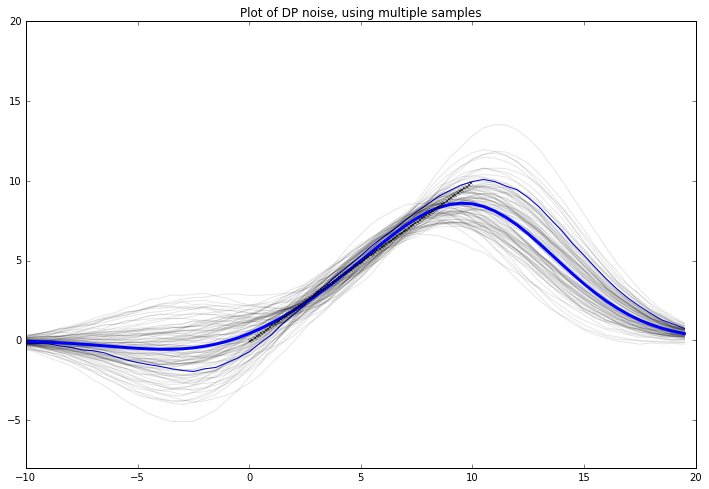

In [163]:
plt.figure(figsize=[12,8])
plt.plot(tests,fsamps[np.random.randint(0,100),:].T);
plt.plot(tests,fsamps[0:100,:].T,'k-',alpha=0.1);
#plt.plot(np.max(fsamps[0:100,:].T,1),'k-',alpha=0.6);
#plt.plot(np.min(fsamps[0:100,:].T,1),'k-',alpha=0.6);
plt.plot(tests,mu,'b-',lw=3);
plt.ylim([-8,20])
plt.title('Plot of DP noise, using multiple samples')
plt.plot(train,y,'kx',markersize=3)

The solid blue line is the non-DP mean prediction.
The thin blue line is a random example of the DP perturbed mean.
Lots of other samples are drawn to demonstrate the scale of noise.
Black crosses indicate training data.

Below is a plot showing how the noise scale varies over the domain.

### PARAMETERS

- DP: $(\varepsilon = 2.0, \delta=0.01)$ ($y_\Delta = 8.0$)
- There are about 100 training points
- The lengthscale is 3.0
- Sample gaussian noise standard deviation set to 1.0
- Sensitivity is set to 8

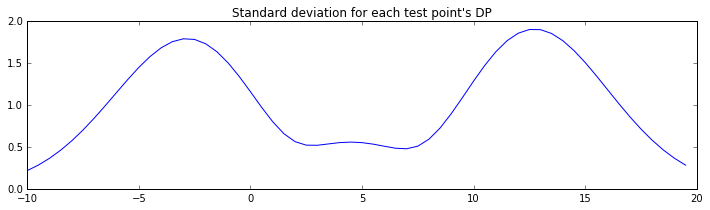

In [165]:
plt.figure(figsize=[12,3])
plt.plot(tests,np.sqrt(np.diag(sampcov)))
plt.ylim([0,2])
plt.title('Standard deviation for each test point\'s DP')

### Notes on DP noise variance over the domain

The function above has a few properties that are worth noting:

- The least noise is far from the data. This is expected: these distant test points are only slightly changed by the training data's perturbations - we only need to add a little DP noise there. If we were to compute the GP posterior variance for these points we would find that is large.

- The most noise is for around the 'edges' of the data. This is, I think, because a single training point on the edge of the dataset can cause a large change in test point values - becuase of the 'amplification' effect of shifting the posterior mean against the fulcrum of the mass of training data behind it.

- Less noise is in the midst of the training data - this is also expected - perturbing a training point here will have little effect on the posterior predictions.

Other notes

- It might not be quite symmetric - with the naive method for P's (cov's) creation, the order the training points are examined matters.

- The 'crinkly' short-length scale noise that appears in the samples above is due to the non-zero diagonal covariance I start with when constructing P (aka cov).

- We are allowed to report these DP variances (along with the GP posterior variance): So a user is able to know where in the domain the prediction is probably quite confident. E.g. here it would be most accurate between x = 2 and x = 8. 

### Future work

- Combine with inducing inputs (protects from outliers)
- Manipulate GP covariance function (either directly, or by adjusting $\sigma$ for each training point).
- Improve how we construct P (cov) so we can reduce the noise.
- Test for multiple dimensions